## Sentiment Classification: classifying IMDB reviews

In this task, you will learn how to process text data and how to train neural networks with limited input text data using pre-trained embeddings for sentiment classification (classifying a review document as "positive" or "negative" based solely on the text content of the review).

We will use the `Embedding` layer in Keras to represent text input. The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, then looks up these integers into an internal dictionary, and finally returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have  shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer.

You can instantiate the `Embedding` layer by randomly initialising its weights (its internal dictionary of token vectors). During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for. You can also instantiate the `Embedding` layer by intialising its weights using the pre-trained word embeddings, such as GloVe word embeddings pretrained from Wikipedia articles.

#### a) Download the IMDB data as raw text

First, create a "data" directory, then head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Save it into the "data" directory. Uncompress it. Store the individual reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a separate `labels` list.

In [1]:
import os

# write your code here

import random
from keras.utils import to_categorical
import numpy as np

""" Declaring directory paths """

data_dir = "./aclImdb/"

pos_test = "test/pos/"
neg_test = "test/neg/"

pos_train = "train/pos/"
neg_train = "train/neg/"


""" Arranging review filepaths """

pos_test_names = [data_dir+pos_test+i for i in os.listdir(data_dir+pos_test)]
neg_test_names = [data_dir+neg_test+i for i in os.listdir(data_dir+neg_test)]

pos_train_names = [data_dir+pos_train+i for i in os.listdir(data_dir+pos_train)]
neg_train_names = [data_dir+neg_train+i for i in os.listdir(data_dir+neg_train)]


""" Sorting train set and labels """

# fetching pos train set
random.seed(5)
random.shuffle(pos_train_names)
pos_train_set = pos_train_names[:500]

# fething neg train set 
random.seed(5)
random.shuffle(neg_train_names)
neg_train_set = neg_train_names[:500]


train_set = []
train_labels =[]

for i in pos_train_set:
    with open(i, encoding="utf-8") as f:
        lines = f.readlines()
        s = "".join(lines)
        train_set.append(s)
        train_labels.append(1)
        
for i in neg_train_set:
    with open(i, encoding="utf-8") as f:
        lines = f.readlines()
        s= "".join(lines)
        train_set.append(s)
        train_labels.append(0)
        
train_y = to_categorical(np.array(train_labels))


""" Sorting validation set """

# validation set will include 100 reviews
pos_val_set = pos_train_names[-50:]
neg_val_set = neg_train_names[-50:]

val_set = []
val_labels = []

for i in pos_val_set:
    with open(i, encoding="utf-8") as f:
        lines = f.readlines()
        s = "".join(lines)
        val_set.append(s)
        val_labels.append(1)
        
for i in neg_val_set:
    with open(i, encoding="utf-8") as f:
        lines = f.readlines()
        s= "".join(lines)
        val_set.append(s)
        val_labels.append(0)


""" Sorting test set and labels """

test_set = []
test_labels =[]

for i in pos_test_names:
    with open(i, encoding="utf-8") as f:
        lines = f.readlines()
        s = "".join(lines)
        test_set.append(s)
        test_labels.append(1)
        
for i in neg_test_names:
    with open(i, encoding="utf-8") as f:
        lines = f.readlines()
        s= "".join(lines)
        test_set.append(s)
        test_labels.append(0)

test_y = to_categorical(np.array(test_labels))

#full = train_set + test_set

Using TensorFlow backend.


#### b) Pre-process the review documents 

Pre-process review documents by tokenisation and split the data into the training and testing sets. You can restrict the training data to the first 1000 reviews and only consider the top 5,000 words in the dataset. You can also cut reviews after 100 words (that is, each review contains a maximum of 100 words).

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# write your code here

max_words = 5000
seq_len = 100

# initiate tokeniser with max words 5000 and lowercase the text
tokeniser = Tokenizer(num_words=max_words, lower=True)

# fit on train set
tokeniser.fit_on_texts(train_set)

# converts text to sequences (replace text with numbers)
sequences = tokeniser.texts_to_sequences(train_set)

# prints number of unique tokens
word_index = tokeniser.word_index
print('Found {} unique tokens.'.format(len(word_index)))

# sets all reviews to length 100
data = pad_sequences(sequences, maxlen = seq_len)


""" Test prepoc """

# initiate tokeniser with max words 5000 and lowercase the text
tkn = Tokenizer(num_words=max_words, lower=True)
# fit on train set
tkn.fit_on_texts(test_set)

# converts text to sequences (replace text with numbers)
seqs = tokeniser.texts_to_sequences(test_set)

# prints number of unique tokens
wi = tkn.word_index
print('Found {} unique tokens.'.format(len(wi)))

# sets all reviews to length 100
test_data = pad_sequences(seqs, maxlen = seq_len)

Found 18969 unique tokens.
Found 87393 unique tokens.


#### c) Download the GloVe word embeddings and map each word in the dataset into its pre-trained GloVe word embedding.

First go to `https://nlp.stanford.edu/projects/glove/` and download the pre-trained 
embeddings from 2014 English Wikipedia into the "data" directory. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

Parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number vectors).

Build an embedding matrix that will be loaded into an `Embedding` layer later. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [3]:
# write your code here


""" Importing glove embeddings """

embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))


""" Creating embedding matrix """

# initialise a zero matrix
embedding_matrix = np.zeros((len(word_index) + 1, seq_len))

# compute matrix
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


#### d) Build and train a simple Sequential model

The model contains an Embedding Layer with maximum number of tokens to be 10,000 and embedding dimensionality as 100. Initialise the Embedding Layer with the pre-trained GloVe word vectors. Set the maximum length of each review to 100. Flatten the 3D embedding output to 2D and add a Dense Layer which is the classifier. Train the model with a 'rmsprop' optimiser. You need to freeze the embedding layer by setting its `trainable` attribute to `False` so that its weights will not be updated during training.

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# write your code here


""" Building simple model """

# set batch size
batch = 32

# initialise the model
model = Sequential()

# add embedding layer 
model.add(Embedding(len(word_index) + 1,
                    100,
                    weights = [embedding_matrix],
                    input_length=seq_len,
                    trainable=False
                    ))


# flatten the model to convert output to 2d from 3d
model.add(Flatten())

# add a dense layer
model.add(Dense(2))

# compile the model
model.compile(
        loss="categorical_crossentropy",
        optimizer = "rmsprop",
        metrics=['acc']
        )


""" Fitting model """

simple = model.fit(
        x = data,
        y = train_y,
        validation_split = 0.1,  # 10% will be used for validation
        verbose = 1, # useful to see whats going on
        shuffle = False,  # for reproducibility 
        epochs = 50,
        batch_size = batch
        )



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 417us/step - loss: 7.9715 - acc: 0.5378 - val_loss: 13.0557 - val_acc: 0.0000e+00
Epoch 2/50
900/900 [==============================] - 0s 46us/step - loss: 8.3221 - acc: 0.7044 - val_loss: 11.7662 - val_acc: 1.0000
Epoch 3/50
900/900 [==============================] - 0s 41us/step - loss: 7.6471 - acc: 0.4444 - val_loss: 11.7662 - val_acc: 1.0000
Epoch 4/50
900/900 [==============================] - 0s 36us/step - loss: 7.6471 - acc: 0.4444 - val_loss: 11.7662 - val_acc: 1.0000
Epoch 5/50
900/900 [==============================] - 0s 36us/step - loss: 7.6471 - acc: 0.4444 - val_loss: 11.7662 - val_acc: 1.0000
Epoch 6/50
900/900 [==============================] - 0s 37us/step - loss: 7.6471 - acc: 0.4444 - val_loss: 11.7662 - val_acc: 1.0000
Epoch 7/50
900/900 [=====

#### e) Plot the training and validation loss and accuracies and evaluate the trained model on the test set.

What do you observe from the results?

In [5]:
import matplotlib.pyplot as plt

# write your code here

""" Plotting Loss Curves """

plt.plot(simple.history["loss"], label="Train")
plt.plot(simple.history["val_loss"], label="Validation")
plt.title('Simple Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


""" Plotting accuracy curves """

plt.plot(simple.history["acc"], label="Train")
plt.plot(simple.history["val_acc"], label="Validation")
plt.title('Simple Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


""" Evaluating on test data """

acc_1 = model.evaluate(
        x = test_data,
        y= test_y
        )

print("simple model accuracy: ", acc_1[1])



"""
Results:
    Both graphs are separted horizontal lines with validatio showing an
    accuracy of 1. This is seems suspicious as it is too good to be true.
    Further investigation is required. 
"""


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

25000/25000 [==============================] - 0s 13us/step
simple model accuracy:  0.5


'\nResults:\n    Both graphs are separted horizontal lines with validatio showing an\n    accuracy of 1. This is seems suspicious as it is too good to be true.\n    Further investigation is required. \n'

#### f) Add an LSTM layer into the simple neural network architecture and re-train the model on the training set, plot the training and validation loss/accuracies, also evaluate the trained model on the test set and report the result.

Train on 900 samples, validate on 100 samples
Epoch 1/5
900/900 [==============================] - 34s 38ms/step - loss: 5.0585 - acc: 0.5578 - val_loss: 1.4506 - val_acc: 1.0000
Epoch 2/5
900/900 [==============================] - 33s 36ms/step - loss: 9.1349 - acc: 0.6222 - val_loss: 11.4660 - val_acc: 0.9900
Epoch 3/5
900/900 [==============================] - 35s 38ms/step - loss: 7.6476 - acc: 0.4456 - val_loss: 13.5392 - val_acc: 1.0000
Epoch 4/5
900/900 [==============================] - 37s 41ms/step - loss: 6.6203 - acc: 0.4356 - val_loss: 8.1814 - val_acc: 0.4500
Epoch 5/5
900/900 [==============================] - 34s 37ms/step - loss: 5.5679 - acc: 0.8044 - val_loss: 8.2221 - val_acc: 0.5400


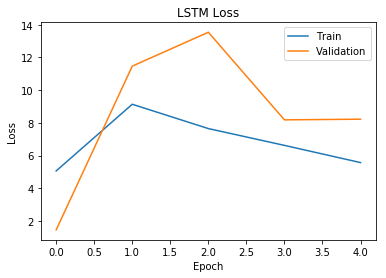

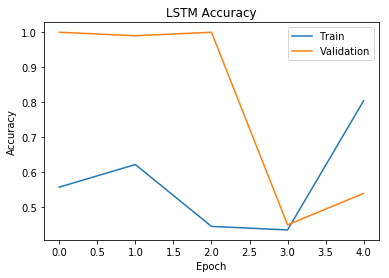

25000/25000 [==============================] - 5s 182us/step
new model accuracy:  0.50736


"\nResults:\n    Our situation hasn't improved but in fact has gotten worse as it seems the \n    validation and train lines have swapped places implying a total faliure. \n    Although the new model does see little improvement in the evaluated accuracy\n    so that could be a win.\n    Further investigation is required to fix this. \n"

In [6]:
from keras.layers import LSTM

# write your code here

""" Building LSTM model """

# setting bath size
batch = 1

# initialise the model
ad = Sequential()

# add embedding layer 
ad.add(Embedding(len(word_index) + 1,
                    100,
                    weights = [embedding_matrix],
                    input_length=seq_len,
                    trainable=False
                    ))

ad.add(LSTM(6, return_sequences=True))

# flatten the model to convert output to 2d from 3d
ad.add(Flatten())

# add a dense layer
ad.add(Dense(2))

# compile the model
ad.compile(
        loss="categorical_crossentropy",
        optimizer = "rmsprop",
        metrics=['acc']
        )


""" Fitting model """

ls = ad.fit(
        x = data,
        y = train_y,
        validation_split = 0.1,
        verbose = 1,
        shuffle = False,
        epochs = 5,
        batch_size = batch
        )

""" Plotting Loss Curves """

plt.plot(ls.history["loss"], label="Train")
plt.plot(ls.history["val_loss"], label="Validation")
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


""" Plotting accuracy curves """

plt.plot(ls.history["acc"], label="Train")
plt.plot(ls.history["val_acc"], label="Validation")
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


""" Test evaluation """

### evaluating ###
acc_2 = ad.evaluate(
        x = test_data,
        y= test_y
        )

print("new model accuracy: ", acc_2[1])

"""
Results:
    Our situation hasn't improved but in fact has gotten worse as it seems the 
    validation and train lines have swapped places implying a total faliure. 
    Although the new model does see little improvement in the evaluated accuracy
    so that could be a win.
    Further investigation is required to fix this. 
"""
